In [2]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
sys.path.append(os.path.expanduser("~/.local/lib/python3.6/site-packages/"))

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [3]:
import time
from pandas import ewma
from IPython import display

# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [5]:
import os

In [6]:
data = pd.read_csv(os.path.expanduser("~/data/DL_data/Train_rev1.csv"), index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
18084,66966686,Event Producer Creative Live Events,A fantastic opportunity to join a leading Crea...,City of London - London,The City,full_time,permanent,CVbrowser,"PR, Advertising & Marketing Jobs",35000,35000,cvbrowser.com,10.463132
83736,69058890,Commercial Property Solicitor **** yrs,Real Estate Commercial Property Solicitor Birm...,Birmingham,Birmingham,NaN,permanent,G2 Legal,Legal Jobs,39000 to 47000 per annum,43000,legalweekjobs.com,10.668979
61443,68696162,Technology Manager – Process Chemistry,Chemistry Innovation is seeking to appoint an ...,Runcorn Cheshire North West,Runcorn,NaN,permanent,Chemistry Innovation Limited,Scientific & QA Jobs,"From 38,000 to 42,000 per annum",40000,totaljobs.com,10.596660


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [7]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [8]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for col in text_columns:
    for line in data[col]:
        token_counts.update(line.split())

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


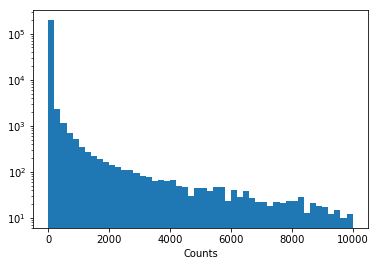

In [12]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(filter(lambda x: token_counts[x] >= min_count, token_counts))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {token: index for index, token in enumerate(tokens)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [21]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [22]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[13576,  3162,   119,   120,   387,   558,  1559,    55,  1702,
          7881],
        [  360,  3030,  1166,    36,     6,   291,  1166,     2,  3358,
           360],
        [ 8830,  1314,  1464,   561,  1497,   858,    55,  1925,    15,
          1126]], dtype=int32),
 'Log1pSalary': array([ 9.384714, 11.191356,  9.433564], dtype=float32),
 'Title': array([[ 119,  120,  176,   63, 1284, 3426,   64],
        [  36,    6, 1058, 1059, 8573,    1,    1],
        [ 116, 1015, 1223,    1,    1,    1,    1]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [93]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim, keepdim=True)[0]
    
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim, keepdim=True)  
    
class GlobalKMaxPooling(nn.Module):
    def __init__(self, dim=-1, k_max=3):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.k_max = k_max
        
    def forward(self, x):
        _, ind = x.topk(k=self.k_max, dim=self.dim)
        ind_sorted = ind.sort(dim=self.dim)[0]
        return x.gather(self.dim, ind_sorted)
    

class AttentivePooling(nn.Module):
    def __init__(self, input_size, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.nn = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
            #nn.Conv1d(input_size, input_size, kernel_size=1, stride=1,)
        )
        
    def forward(self, x):
        output = Variable(torch.FloatTensor(x.shape[0], x.shape[2])).cuda()
        for time_index in range(x.shape[-1]):
            output[..., time_index] = self.nn(x[..., time_index])

        return (x * F.softmax(output, dim=-1)[:, None, :]).sum(dim=-1, keepdim=True)
#         x_conved = self.nn(x)
#         return (x * F.softmax(x_conved, dim=-1)).sum(dim=-1, keepdim=True)

In [94]:
# class LSTM(nn.Module):
#     """
#     Implements something like CharRNNCell, but with LSTM
#     """
#     def __init__(self, embedding_size=None, rnn_num_units=128, num_classes=3, num_tokens=None, num_rnn_layers=1):
#         super(self.__class__,self).__init__()
#         self.num_units = rnn_num_units
#         self.num_rnn_layers = num_rnn_layers
#         self.emb = nn.Embedding(num_tokens, embedding_size)
#         self.lstm = nn.LSTM(embedding_size, rnn_num_units, num_rnn_layers, batch_first=True, dropout=0.3)
        
#         self.dense = nn.Linear(rnn_num_units, rnn_num_units)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout()
#         self.rnn_to_logits = nn.Linear(rnn_num_units, num_classes)
        
#     def forward(self, x, prev_state):
#         # (prev_h, prev_c) = prev_state 
#         lstm_out , prev_state = self.lstm(self.emb(x), prev_state)
        
#         #dense_out = self.dropout(self.relu(self.dense(lstm_out)))
#         logits = self.rnn_to_logits(lstm_out)
#         return logits[:, -1, :]
    
#     def initial_state(self, batch_size):
#         """ LSTM has two state variables, cell and hid """
#         return Variable(torch.zeros(self.num_rnn_layers, batch_size, self.num_units)).cuda(),\
#                Variable(torch.zeros(self.num_rnn_layers, batch_size, self.num_units)).cuda()

In [95]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        
        self.pool1 = GlobalMaxPooling()
        #self.pool2 = GlobalAveragePooling()
        self.pool3 = AttentivePooling(out_size)
        self.pool4 = AttentivePooling(out_size)
        
        self.lstm = nn.LSTM(64, 64, num_layers=1, bidirectional=True)
        
        self.bn = nn.BatchNorm1d(768)
        self.dense = nn.Linear(768, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        out = self.conv1(h)
        
        lstm_out , _ = self.lstm(torch.transpose(h, 1, 2))
        lstm_out = torch.transpose(lstm_out, 1, 2)
        
        pool_list = []
        pool_list.append(self.pool1(out))
        pool_list.append(self.pool3(out))
        pool_list.append(self.pool4(out))
        
        pool_list.append(self.pool1(lstm_out))
        pool_list.append(self.pool3(lstm_out))
        pool_list.append(self.pool4(lstm_out))
        #print([k.shape for k in pool_list])
#         print(out_1.shape, out_2[..., None].shape)
#         print(torch.cat([out_1, out_2[..., None]], dim=-1).shape)
        out = torch.cat(pool_list, dim=-1).view(h.shape[0], -1)
        out = self.bn(out)

#        out = F.relu(out)
#        out = self.pool2(out)
        out = F.relu(out)
        out = self.dense(out)
        
        return out

In [96]:
t_out_size = 128
title_encoder = TitleEncoder(out_size=t_out_size)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], t_out_size)

del title_encoder
print("Seems fine")

RuntimeError: Expected object of type Variable[torch.FloatTensor] but found type Variable[torch.cuda.FloatTensor] for argument #1 'other'

__Task 2.1__ Create description encoder

In [97]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        #self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        #self.conv4 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        
        self.pool1 = GlobalMaxPooling()
        self.pool2 = AttentivePooling(2 * out_size)

        self.pool3 = AttentivePooling(2 * out_size)        
        
        self.lstm = nn.LSTM(64, 128, num_layers=2, bidirectional=True, dropout=0.3)
        
        self.bn = nn.BatchNorm1d(1024)
        self.dense = nn.Linear(1024, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        
        # Parallell convs
        out_1 = self.conv1(h)
        out_2 = self.conv2(h)
#         out_3 = self.conv3(h)
#         out_4 = self.conv4(h)
        
        out = torch.cat([out_1, out_2], dim=1)
        
        #LSTM part
        lstm_out , _ = self.lstm(torch.transpose(h, 1, 2))
        lstm_out = torch.transpose(lstm_out, 1, 2)    
    
        # Pool all part
        pool_list = []
        pool_list.append(self.pool1(out))
        pool_list.append(self.pool2(out))
        pool_list.append(self.pool1(lstm_out))
        pool_list.append(self.pool3(lstm_out))

        out = torch.cat(pool_list, dim=-1).view(h.shape[0], -1)
        
        out = self.bn(out)
        out = F.relu(out)
        out = self.dense(out)
        
        return out

In [64]:
d_out_size = 128
desc_encoder = DescEncoder(out_size=d_out_size)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], d_out_size)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [98]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=128)
        self.desc_encoder = DescEncoder(out_size=128)
        
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 128)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixed_output = nn.Sequential(
            nn.Linear(128 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.mixed_output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [89]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [90]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [123]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)
    #return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [92]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [119]:
from tqdm import tqdm
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    #irange = tnrange if verbose else range
    
    for start in tqdm(range(0, len(indices), batch_size), total=len(indices) / batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [124]:
def train(model, opt, num_epochs, max_len, batch_size, batches_per_epoch): 
    for epoch_i in range(num_epochs):
        start_time = time.time() 
        print("Training:")
        train_loss = train_mae = train_batches = 0    
        model.train(True)

        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, max_len=max_len):

            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            title_ix, desc_ix, cat_features, reference = list(map(lambda x: x.cuda(),
                                                              [title_ix, desc_ix, cat_features, reference]))        

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.cpu().numpy()[0]
            train_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
            train_batches += 1


        train_loss_history.append(train_loss / train_batches)
        train_mae_history.append(train_mae / train_batches)

        print("Validation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, shuffle=False, max_len=max_len):
            title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
            reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

            title_ix, desc_ix, cat_features, reference = list(map(lambda x: x.cuda(),
                                                             [title_ix, desc_ix, cat_features, reference]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()[0]
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
            val_batches += 1

        val_loss_history.append(val_loss / val_batches)
        val_mae_history.append(val_mae / val_batches)        



        display.clear_output(wait=True)
        #plt.figure(figsize=(8, 6))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
        ax1.set_title("Loss")
        ax1.set_xlabel("#Epoch")
        ax1.set_ylabel("loss")
        ax1.plot(train_loss_history, 'b', label='Train loss')
        ax1.plot(val_loss_history, 'r', label='Val loss')
        #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
        ax1.legend(loc='best')
        ax1.grid()
        ax1.set_ylim(0, 1)

        ax2.set_title("MAE")
        ax2.set_xlabel("#Epoch")
        ax2.set_ylabel("MAE")
        ax2.plot(train_mae_history, 'b', label='Train mae')
        ax2.plot(val_mae_history, 'r', label='Val mae')
        #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
        ax2.legend(loc='best')
        ax2.grid()    
        ax2.set_ylim(2000, 10000)
        
        plt.show() 


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch_i + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_history[-1]))
        print("  validation loss:\t\t{:.6f}".format(val_loss_history[-1]))

        print("  training mae (in-iteration): \t{:.3f}".format(train_mae_history[-1]))
        print("  validation mae:\t\t{:.3f}".format(val_mae_history[-1]))    

In [65]:
num_epochs = 100
max_len = 100
batch_size = 64
batches_per_epoch = 100

model = FullNetwork().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []       

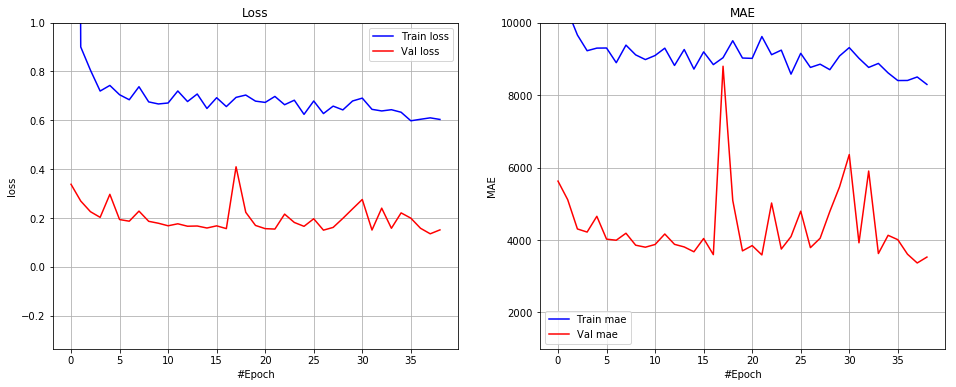

  7%|▋         | 7/100.0 [00:00<00:01, 61.72it/s]

Epoch 12 of 100 took 8.249s
  training loss (in-iteration): 	0.603478
  validation loss:		0.151105
  training mae (in-iteration): 	8293.914
  validation mae:		3528.014
Training:


 47%|████▋     | 47/100.0 [00:00<00:00, 60.59it/s]


KeyboardInterrupt: 

In [68]:
train(model, opt, num_epochs, max_len, batch_size, batches_per_epoch)

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
    desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
    cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
    reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()[0]
    val_mae += compute_mae(reference, prediction).data.numpy()[0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

# A)

In [125]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

model = FullNetwork().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []       

In [126]:
#opt = torch.optim.Adam(model.parameters(), lr=1e-4 / 2)

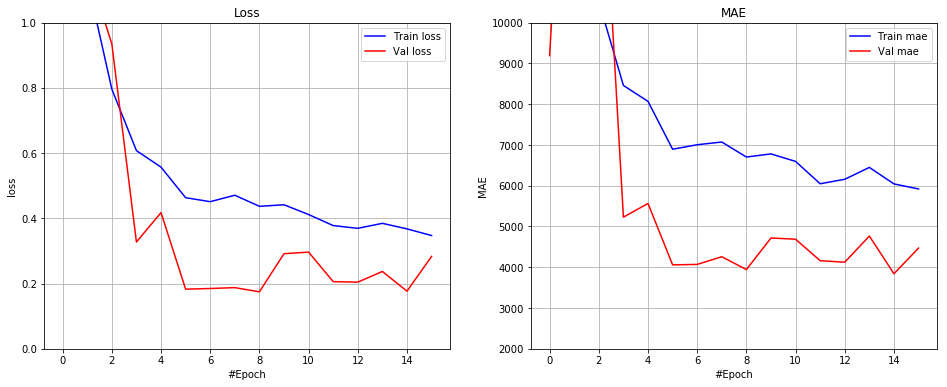

  0%|          | 0/100.0 [00:00<?, ?it/s]

Epoch 16 of 100 took 120.645s
  training loss (in-iteration): 	0.347314
  validation loss:		0.283224
  training mae (in-iteration): 	5920.693
  validation mae:		4470.589
Training:


100%|██████████| 100/100.0 [00:29<00:00,  3.43it/s]
  0%|          | 1/764.90625 [00:00<01:55,  6.62it/s]

Validation:


  4%|▍         | 29/764.90625 [00:03<01:29,  8.20it/s]


KeyboardInterrupt: 

In [127]:
train(model, opt, num_epochs, max_len, batch_size, batches_per_epoch)